# Train with oversampling

In [9]:
# Organize data paths and labels
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def resolve_data_path(data_dir: str):
    normal_dir = os.path.join(data_dir, 'NORMAL')
    pneumonia_dir = os.path.join(data_dir, 'PNEUMONIA')

    normal_paths = [os.path.join(data_dir, 'NORMAL', f) for f in os.listdir(normal_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
    pneumonia_paths = [os.path.join(data_dir, 'PNEUMONIA', f) for f in os.listdir(pneumonia_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
    pathes = normal_paths + pneumonia_paths
    labels = [0]*len(normal_paths) + [1]*len(pneumonia_paths)
    return pd.DataFrame({'path': pathes, 'label': labels})

# Base dir
train_df = resolve_data_path("datasets/all_data")
test_df = resolve_data_path("datasets/test")

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# compute class weights
class_counts = train_df['label'].value_counts().to_dict()
total_samples = len(train_df)
class_weights = {cls: total_samples/count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in train_df['label']]
# ouptput class weights
print("Class Weights:", class_weights)

print(train_df.head(20))

Class Weights: {1: 1.3473921442369607, 0: 3.8785912882298423}
                                                   path  label
3566  datasets/all_data/PNEUMONIA/person1483_bacteri...      1
2866  datasets/all_data/PNEUMONIA/person591_bacteria...      1
2681  datasets/all_data/PNEUMONIA/person361_virus_74...      1
1199  datasets/all_data/NORMAL/NORMAL2-IM-1438-0001....      0
4619  datasets/all_data/PNEUMONIA/person450_bacteria...      1
1008         datasets/all_data/NORMAL/IM-0349-0001.jpeg      0
1295  datasets/all_data/NORMAL/NORMAL2-IM-1261-0001....      0
2688  datasets/all_data/PNEUMONIA/person994_virus_16...      1
3142  datasets/all_data/PNEUMONIA/person1098_bacteri...      1
82    datasets/all_data/NORMAL/NORMAL2-IM-0898-0001....      0
4042  datasets/all_data/PNEUMONIA/person67_bacteria_...      1
5037  datasets/all_data/PNEUMONIA/person886_virus_15...      1
1980  datasets/all_data/PNEUMONIA/person1617_bacteri...      1
4688  datasets/all_data/PNEUMONIA/person333_bacteria... 

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import models
from torchvision.models import ResNet50_Weights, ResNet18_Weights, ResNet34_Weights
from sklearn.metrics import classification_report, roc_auc_score, f1_score, recall_score, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# 0. CUSTOM DATASET
# ===============================
class ChestXrayDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    



# ===============================
# 1. METRICS
# ===============================
def compute_metrics(y_true, y_pred, y_prob):
    recall = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp + 1e-8)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    return recall, specificity, f1, auc


# ===============================
# 2. TRAIN / EVAL FUNCTIONS
# ===============================
def train_epoch_binary(model, loader, criterion, optimizer, threshold=0.5):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        preds = (torch.sigmoid(outputs) >= threshold).int()
        correct += (preds.cpu() == labels.cpu().int()).sum().item()
        total += labels.size(0)

    return running_loss / len(loader.dataset), correct / total


def eval_epoch_binary(model, loader, criterion, threshold=0.5):
    model.eval()
    running_loss = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy().flatten())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    preds = (all_probs >= threshold).astype(int)

    return running_loss / len(loader.dataset), preds, all_labels, all_probs


# ===============================
# 3. CROSS-VALIDATION PIPELINE
# ===============================
def cross_validate(df, train_transform, val_test_transform, n_splits=5, batch_size=32, lr=1e-4, num_epochs=12, threshold=0.5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
        print(f"\n===== Fold {fold+1} / {n_splits} =====")

        train_subset = Subset(ChestXrayDataset(df, transform=train_transform), train_idx)
        val_subset   = Subset(ChestXrayDataset(df, transform=val_test_transform), val_idx)

        # Oversampling sampler
        train_labels = df.iloc[train_idx]['label']
        class_counts = train_labels.value_counts().to_dict()
        total = len(train_labels)
        class_weights = {cls: total/cnt for cls, cnt in class_counts.items()}
        sample_weights = [class_weights[l] for l in train_labels]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler, num_workers=4)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

        # Model, criterion, optimizer
        # model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, 1)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        best_balanced = 0
        best_model_path = f"best_model_fold{fold+1}.pth"

        # Training loop
        for epoch in range(num_epochs):
            train_loss, train_acc = train_epoch_binary(model, train_loader, criterion, optimizer, threshold=threshold)
            val_loss, val_preds, val_trues, val_probs = eval_epoch_binary(model, val_loader, criterion, threshold=threshold)

            recall, spec, f1, auc = compute_metrics(val_trues, val_preds, val_probs)
            balanced = (recall + spec) / 2
            acc = accuracy_score(val_trues, val_preds)

            print(f"Epoch {epoch+1}/{num_epochs} | TrainLoss={train_loss:.4f} | TrainAcc={train_acc:.4f}"
                  f" | ValAcc={acc:.4f} | ValRec={recall:.3f} | ValSpec={spec:.3f} | BalAcc={balanced:.3f} | AUC={auc:.3f}")

            if balanced > best_balanced:
                best_balanced = balanced
                torch.save(model.state_dict(), best_model_path)
                print(" --> Saved Best Model")

        # Evaluate fold
        val_loss, val_preds, val_trues, val_probs = eval_epoch_binary(model, val_loader, criterion)
        recall, spec, f1, auc = compute_metrics(val_trues, val_preds, val_probs)
        fold_results.append({
            "fold": fold+1,
            "recall": recall,
            "specificity": spec,
            "f1": f1,
            "auc": auc
        })

    return fold_results

In [12]:
from torchvision import transforms
# define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # convert to grayscale
    # transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    # Normalize with ImageNet stats, beacause resnet is pretrained on ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# ===============================
# 4. RUN CROSS-VALIDATION
# ===============================
fold_metrics = cross_validate(train_df, train_transform, val_test_transform, n_splits=5, num_epochs=5, threshold=0.6)
for fm in fold_metrics:
    print(f"Fold {fm['fold']}: Recall={fm['recall']:.3f}, Spec={fm['specificity']:.3f}, F1={fm['f1']:.3f}, AUC={fm['auc']:.3f}")

# compute mean and std of fold metrics
mean_recall = np.mean([fm['recall'] for fm in fold_metrics])
std_recall = np.std([fm['recall'] for fm in fold_metrics])
mean_spec = np.mean([fm['specificity'] for fm in fold_metrics])
std_spec = np.std([fm['specificity'] for fm in fold_metrics])
mean_f1 = np.mean([fm['f1'] for fm in fold_metrics])
std_f1 = np.std([fm['f1'] for fm in fold_metrics])
mean_auc = np.mean([fm['auc'] for fm in fold_metrics])
std_auc = np.std([fm['auc'] for fm in fold_metrics])

print(f"\n=== CROSS-VALIDATION SUMMARY ===")
print(f"Recall     : {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Specificity: {mean_spec:.4f} ± {std_spec:.4f}")
print(f"F1 Score   : {mean_f1:.4f} ± {std_f1:.4f}")
print(f"AUC        : {mean_auc:.4f} ± {std_auc:.4f}")


In [ ]:
# sechedule learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from torchvision.models import ResNet34_Weights, ResNet50_Weights, ResNet18_Weights


# ===============================
# 5. Train FINAL MODEL ON FULL TRAINING SET & EVALUATE ON TEST SET
# ===============================
# Using best hyperparameters from CV
best_lr = 1e-4
best_BC = 32
threshold = 0.6


# Create dataloaders
train_dataset = ChestXrayDataset(train_df, transform=train_transform)
val_dataset = ChestXrayDataset(val_df, transform=val_test_transform)
test_dataset = ChestXrayDataset(test_df, transform=val_test_transform)

# Oversampling sampler
train_labels = train_df['label']
class_counts = train_labels.value_counts().to_dict()
total = len(train_labels)
class_weights = {cls: total/cnt for cls, cnt in class_counts.items()}
sample_weights = [class_weights[l] for l in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=best_BC, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=best_BC, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=best_BC, shuffle=False, num_workers=4)

# Model, criterion, optimizer
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(model.fc.in_features, 1)  # binary classification
model = model.to(device)
# model = BinaryClassifier()
# model = model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

num_epochs = 15
best_balanced = 0.0
best_path = "best_res18_model.pth"

train_losses = []
val_losses = []
val_accs = []
val_recalls = []
val_specs = []
val_f1s = []
val_aucs = []

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_binary(model, train_loader, criterion, optimizer, threshold=threshold)
    val_loss, val_preds, val_trues, val_probs = eval_epoch_binary(model, val_loader, criterion, threshold=threshold)

    scheduler.step(val_loss)
    lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{num_epochs} | Learning Rate: {lr:.6f}")

    recall, spec, f1, auc = compute_metrics(val_trues, val_preds, val_probs)
    balanced = (recall + spec) / 2
    acc = accuracy_score(val_trues, val_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(acc)
    val_recalls.append(recall)
    val_specs.append(spec)
    val_f1s.append(f1)
    val_aucs.append(auc)

    print(f"Epoch {epoch+1}/{num_epochs} | TrainLoss={train_loss:.4f} | TrainAcc={train_acc:.4f}"
          f" | ValAcc={acc:.4f} | ValRec={recall:.3f} | ValSpec={spec:.3f} | BalAcc={balanced:.3f} | AUC={auc:.3f}")

    if balanced > best_balanced:
        best_balanced = balanced
        torch.save(model.state_dict(), best_path)
        print(" --> Saved Best Model")


/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15 | Learning Rate: 0.000100
Epoch 1/15 | TrainLoss=0.1184 | TrainAcc=0.9568 | ValAcc=0.9532 | ValRec=0.938 | ValSpec=0.996 | BalAcc=0.967 | AUC=0.998
 --> Saved Best Model
Epoch 2/15 | Learning Rate: 0.000100
Epoch 2/15 | TrainLoss=0.0414 | TrainAcc=0.9845 | ValAcc=0.9618 | ValRec=0.950 | ValSpec=0.996 | BalAcc=0.973 | AUC=0.998
 --> Saved Best Model
Epoch 3/15 | Learning Rate: 0.000100
Epoch 3/15 | TrainLoss=0.0557 | TrainAcc=0.9828 | ValAcc=0.9694 | ValRec=0.961 | ValSpec=0.993 | BalAcc=0.977 | AUC=0.998
 --> Saved Best Model
Epoch 4/15 | Learning Rate: 0.000100
Epoch 4/15 | TrainLoss=0.0510 | TrainAcc=0.9826 | ValAcc=0.9838 | ValRec=0.982 | ValSpec=0.989 | BalAcc=0.985 | AUC=0.999
 --> Saved Best Model
Epoch 5/15 | Learning Rate: 0.000100
Epoch 5/15 | TrainLoss=0.0362 | TrainAcc=0.9873 | ValAcc=0.9876 | ValRec=0.991 | ValSpec=0.978 | BalAcc=0.984 | AUC=0.999
Epoch 6/15 | Learning Rate: 0.000100
Epoch 6/15 | TrainLoss=0.0301 | TrainAcc=0.9897 | ValAcc=0.9847 | ValRec=0.988 |

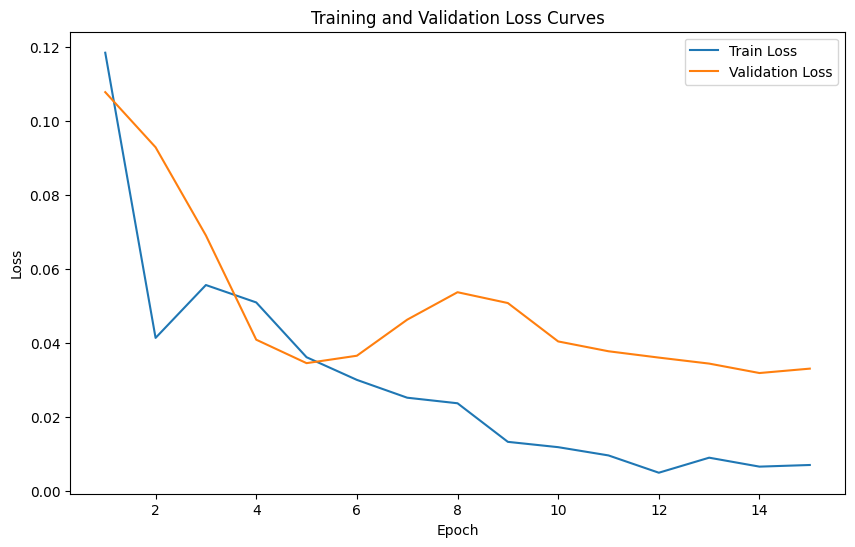

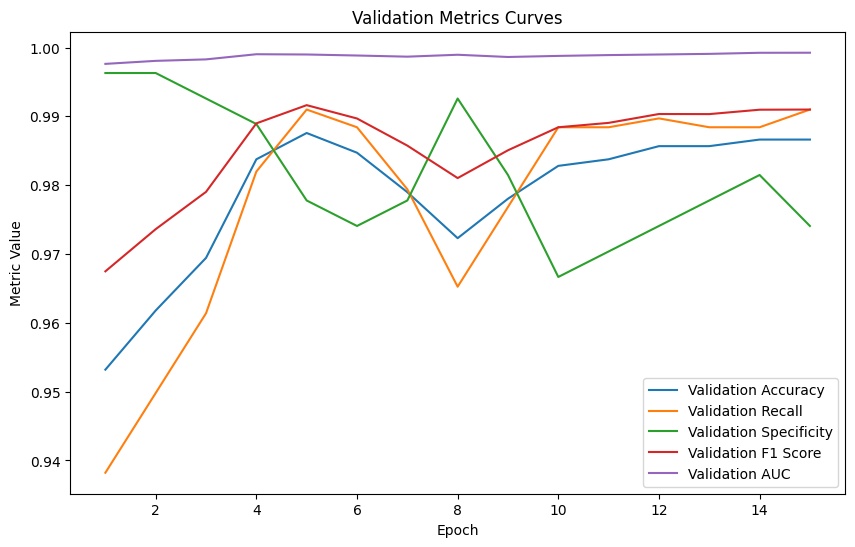

In [22]:
# plot training and validation loss curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()
# plot validation metrics curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
plt.plot(range(1, num_epochs+1), val_recalls, label='Validation Recall')
plt.plot(range(1, num_epochs+1), val_specs, label='Validation Specificity')
plt.plot(range(1, num_epochs+1), val_f1s, label='Validation F1 Score')
plt.plot(range(1, num_epochs+1), val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Metrics Curves')
plt.legend()
plt.show()

In [ ]:
from torchvision import models
from torchvision.models import ResNet18_Weights
import torch
from sklearn.metrics import classification_report, accuracy_score
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_path = "best_res18_model.pth"
# Load best model and evaluate on test set
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load(best_path))
model.to(device)

test_dataset = ChestXrayDataset(test_df, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

criterion = nn.BCEWithLogitsLoss()

test_loss, test_preds, test_trues, test_probs = eval_epoch_binary(model, test_loader, criterion, threshold=0.7)
recall, spec, f1, auc = compute_metrics(test_trues, test_preds, test_probs)
acc = accuracy_score(test_trues, test_preds)

print("\n=== FINAL TEST METRICS ===")
print(f"Test Accuracy: {acc:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"AUC        : {auc:.4f}")

print("\nClassification Report:")
print(classification_report(test_trues, test_preds, target_names=["Normal", "Pneumonia"]))

NameError: name 'criterion' is not defined